In [2]:
# Librerías y paquetes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
import colorednoise as cn
import random 
import pickle as pkl

In [3]:
from pathlib import Path
def make_gravitational_waves(
    path_to_data: Path,
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 1,
        ):
    
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad =500  # number of padding points on either side of the vector
    #gw = np.load(path_to_data / "gravitational_wave_signals.npy")
    #../input/gravitational-wave-signals/gravitational_wave_signals.npy
    gw = np.load("gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * np.random.randn(N)
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, labels

In [4]:
#from data.generate_datasets import make_gravitational_waves
from pathlib import Path

n_signals = 1500
DATA = Path("./data")

noisy_gausignals, gw_gausignals, gau_labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=0.025, r_max=0.65, n_snr_values=100
)



In [5]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# get the index corresponding to the first pure noise time series
background_idx = np.argmin(gau_labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(gau_labels)

ts_noise = noisy_gausignals[background_idx]
ts_background = noisy_gausignals[signal_idx]
ts_signal = gw_gausignals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split

In [7]:
# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [63]:
data = np.array(noisy_gausignals)

#Scale the data
data = data / np.max(data)

# Convert the data end labels to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32).to(device)
labels = torch.tensor(gau_labels, dtype=torch.float32).to(device)


#Unsqueeze the data to add a channel dimension
data = data.unsqueeze(1)

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# print the amount of 1 in the labels
print(f"Number of 1s in the labels: {int(torch.sum(test_labels))}")
print(f"Number of 0s in the labels: {len(test_labels) - int(torch.sum(test_labels))}")



# Create TensorDatasets for training and testing
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Shape of the data
print(f"Shape of the training data: {train_data.shape}")

Number of 1s in the labels: 135
Number of 0s in the labels: 165
Shape of the training data: torch.Size([1200, 1, 8692])


In [9]:
class GWCNN(nn.Module):
    def __init__(self):
        super(GWCNN, self).__init__()
      # First convolution block
        self.conv1 = nn.Conv1d(1, 16, kernel_size=16, stride=1)
        self.bnn1 = nn.BatchNorm1d(16)
        self.act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=4)
        #self.fc1 = nn.Linear(2165, 512)  # 'reduced_dim1' needs to be calculated
    

        # Second convolution block
        self.conv2 = nn.Conv1d(16, 32, kernel_size=16, stride=1, padding=1)
        self.bnn2 = nn.BatchNorm1d(32)
        self.act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=4, padding=0)
        #self.fc2 = nn.Linear(125, 128)  # 'reduced_dim2' needs to be calculated
      
        
        # Third convolution block
        self.conv3 = nn.Conv1d(32, 64, kernel_size=4, stride=1, padding=1)
        self.bnn3 = nn.BatchNorm1d(64)
        self.act3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=4, padding=0)
        #self.fc3 = nn.Linear(32, 32)  # 'reduced_dim3' needs to be calculated

        # Fourth convolution block
        self.conv4 = nn.Conv1d(64, 128, kernel_size=8, stride=1)
        self.bnn4 = nn.BatchNorm1d(128)
        self.act4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool1d(kernel_size=4, stride=4)
        #self.fc4 = nn.Linear(6, 4)  # 'reduced_dim4' needs to be calculated
        

        # Flattening for final dense layers
        self.flatten = nn.Flatten()
        self.fc5 = nn.Linear(4096, 512)
        self.act5 = nn.ReLU()
        self.fc6 = nn.Linear(512, 128)
        self.act6 = nn.ReLU()
        self.fc7 = nn.Linear(128, 32)
        self.act7 = nn.ReLU()
        self.fc8 = nn.Linear(32, 2)

    def forward(self, x):
        
        # First convolution block
        x = self.conv1(x)
        x = self.bnn1(x)
        x = self.act1(x)
        #x = self.fc1(x)
        x = self.maxpool1(x)
      
        #print("Bloque 1: ", x.shape)

        # Second convolution block
        x = self.conv2(x)
        x = self.bnn2(x)
        x = self.act2(x)
        x = self.maxpool2(x)
        #x = self.fc2(x)
        #print("Bloque 2: ", x.shape)
        
        # Third convolution block
        x = self.conv3(x)
        x = self.bnn3(x)
        x = self.act3(x)
        x = self.maxpool3(x)
        #x = self.fc3(x)
        #print("Bloque 3: ", x.shape)

        # Fourth convolution block
        x = self.conv4(x)
        x = self.bnn4(x)
        x = self.act4(x)
        x = self.maxpool4(x)
        #x = self.fc4(x)
        #print("Bloque 4: ", x.shape)

        # Flattening for final dense layers
        x = self.flatten(x)
        
        x = self.fc5(x)
        x = self.act5(x)
      
        x = self.fc6(x)
        x = self.act6(x)

        x = self.fc7(x)
        x = self.act7(x)

        x = self.fc8(x)
        #print("GG")
        return x

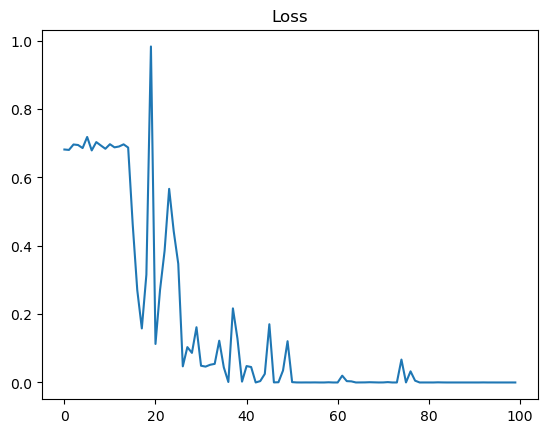

In [64]:
model = GWCNN().to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

losses = []

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels.long())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #save the loss of each epoch for plotting but only the first 2 digits
    losses.append(loss.item())


#plot the loss
plt.plot(losses) 
plt.title("Loss")
plt.show()

# Save the trained model
#torch.save(model.state_dict(), "GW_Paper.pth")

In [65]:
#test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted = predicted.cpu().numpy()
        print(predicted)


print(f"Accuracy: {100 * correct / total}")

[0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0]
[1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0]
[0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0]
[1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0]
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0]
[0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 1 0]
[0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0]
[0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0]
[0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 1]
[0 1 1 1 1 1 0 0 0 1 0 0]
Accuracy: 87.0


In [12]:
def generate_cauchy_noise(signal_length, scale=1.0):
    """
    Generate a Cauchy noise array with a specified length and scale parameter.
    
    Parameters:
    signal_length (int): The length of the output noise array.
    scale (float): The scale parameter of the Cauchy distribution.
    
    Returns:
    numpy array: An array of Cauchy noise with the specified length.
    """
    # Generate Cauchy noise
    cauchy_noise = np.random.standard_cauchy(size=signal_length) * scale
    
    return cauchy_noise

def make_gravitational_waves_cauchy(
    # Cambiar el path 
    path_to_data: Path,
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
):
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        cut = n-1 if cut==n else (1 if cut==0 else cut)
        rand1_length = cut # Ensure length is at least 1
        rand2_length = n - cut  # Ensure length is at least 1
        rand1 = generate_cauchy_noise(rand1_length)  # Generate Brownian noise for padding
        rand2 = generate_cauchy_noise(rand2_length)  # Generate Brownian noise for padding
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    gw = np.load("gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * generate_cauchy_noise(N)  # Generate Brownian noise for the main signal
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, labels

In [58]:
#from data.generate_datasets import make_gravitational_waves
from pathlib import Path

n_signals = 1500
DATA = Path("./data")

noisy_causignals, gw_causignals, cau_labels = make_gravitational_waves_cauchy(
      path_to_data=DATA,n_signals=n_signals, r_min=0.025, r_max=0.65, n_snr_values=1
)


In [59]:
data = np.array(noisy_causignals)

#Scale the data
data = data / np.max(data)

# Convert the data end labels to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32).to(device)
labels = torch.tensor(cau_labels, dtype=torch.float32).to(device)


#Unsqueeze the data to add a channel dimension
data = data.unsqueeze(1)

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# print the amount of 1 in the labels
print(f"Number of 1s in the labels: {int(torch.sum(test_labels))}")
print(f"Number of 0s in the labels: {len(test_labels) - int(torch.sum(test_labels))}")



# Create TensorDatasets for training and testing
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Shape of the data
print(f"Shape of the training data: {train_data.shape}")



Number of 1s in the labels: 162
Number of 0s in the labels: 138
Shape of the training data: torch.Size([1200, 1, 8692])


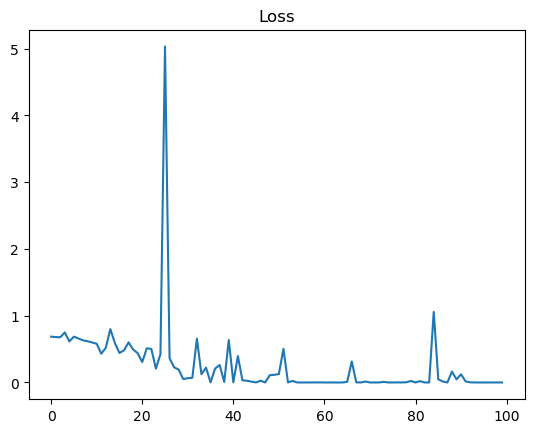

In [60]:
model = GWCNN().to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

losses = []

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels.long())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #save the loss of each epoch for plotting but only the first 2 digits
    losses.append(loss.item())


#plot the loss
plt.plot(losses) 
plt.title("Loss")
plt.show()

# Save the trained model
#torch.save(model.state_dict(), "GW_Paper.pth")

In [62]:
#test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted = predicted.cpu().numpy()
        print(predicted)


print(f"Accuracy: {100 * correct / total}")

[1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0]
[1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0]
[1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1]
[0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1]
[0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0]
[1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0]
[0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0]
[0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0]
[1 0 0 1 0 0 1 0 0 0 0 0]
Accuracy: 47.666666666666664


In [17]:
def generate_blue_noise(signal_length, beta=-1):
    
    # Generate white noise
    white_noise = np.random.randn(signal_length)
    
    # Apply Fourier Transform to the white noise
    freqs = np.fft.rfftfreq(signal_length)
    fft_white_noise = np.fft.rfft(white_noise)
    
    # Create a frequency filter based on beta
    # For blue noise, the filter is proportional to f^beta where beta = -1
    filter_blue = np.zeros_like(freqs)
    non_zero_freqs = freqs > 0 # Filtrar ondas válidas
    filter_blue[non_zero_freqs] = freqs[non_zero_freqs] ** (beta / 2.0)
    
    # Apply the filter to the Fourier coefficients
    fft_blue_noise = fft_white_noise * filter_blue
    
    # Apply the inverse Fourier Transform to get back to time domain
    blue_noise = np.fft.irfft(fft_blue_noise, n=signal_length)
    
    # Normalize the Blue noise to have zero mean and unit variance
    blue_noise -= np.mean(blue_noise)
    blue_noise /= np.std(blue_noise)
    
    return blue_noise

def make_gravitational_waves_blue(
    n_signals: int = 30,
    downsample_factor: int = 2,

    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
):
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        cut = n-1 if cut==n else (1 if cut==0 else cut)
        rand1_length = cut # Ensure length is at least 1
        rand2_length = n - cut  # Ensure length is at least 1
        rand1 = generate_blue_noise(rand1_length)  # Generate blue noise for padding
        rand2 = generate_blue_noise(rand2_length)  # Generate blue noise for padding
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    gw = np.load("gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        if Rcoef[j % n_snr_values] == 0:
            print(Rcoef[j % n_snr_values])
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * generate_blue_noise(N)  # Generate blue noise for the main signal
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, labels




In [18]:
#from data.generate_datasets import make_gravitational_waves
from pathlib import Path

n_signals = 1500
DATA = Path("./data")

noisy_bluesignals, gw_bluesignals, blue_labels = make_gravitational_waves_blue(
      n_signals=n_signals, r_min=100, r_max=100, n_snr_values=100
)


C:\Users\Admin\AppData\Local\Temp\ipykernel_12556\608689636.py:24: RuntimeWarning:

invalid value encountered in divide



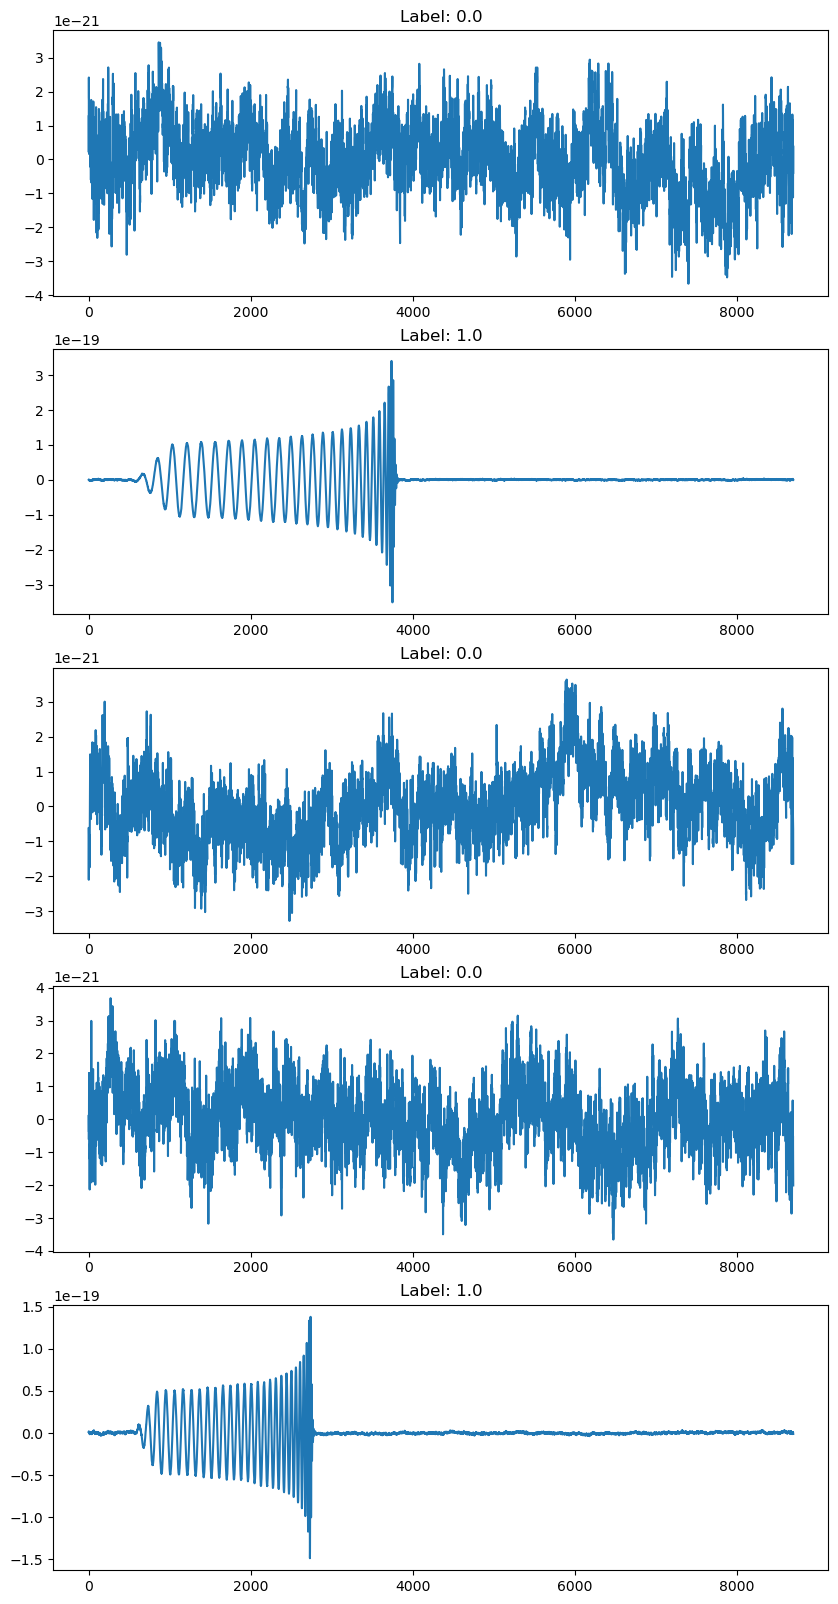

In [19]:
#plot first 5 signals and its labels
fig, axs = plt.subplots(5, 1, figsize=(10, 20))
for i in range(5):
    axs[i].plot(noisy_bluesignals[i])
    axs[i].set_title(f"Label: {blue_labels[i]}")
plt.show()


In [20]:
data = np.array(noisy_bluesignals)

#Scale the data
data = data / np.max(data)

# Convert the data end labels to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32).to(device)
labels = torch.tensor(blue_labels, dtype=torch.float32).to(device)


#Unsqueeze the data to add a channel dimension
data = data.unsqueeze(1)

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# print the amount of 1 in the labels
print(f"Number of 1s in the labels: {int(torch.sum(test_labels))}")
print(f"Number of 0s in the labels: {len(test_labels) - int(torch.sum(test_labels))}")



# Create TensorDatasets for training and testing
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Shape of the data
print(f"Shape of the training data: {train_data.shape}")



Number of 1s in the labels: 156
Number of 0s in the labels: 144
Shape of the training data: torch.Size([1200, 1, 8692])


Epoch 1/20: 

loss:nan:.4f:  11%|█         | 4/38 [00:00<00:00, 36.91it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  11%|█         | 4/38 [00:00<00:00, 36.91it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  11%|█         | 4/38 [00:00<00:00, 36.91it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 49.05it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  76%|███████▋  | 29/38 [00:00<00:00, 67.51it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound met

loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 66.16it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
Training loss = nan
Epoch 2/20: 

loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 109.73it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound met

loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 109.73it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 107.13it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound met

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 106.48it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound met

loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 106.48it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 109.90it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound met

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  32%|███▏      | 12/38 [00:00<00:00, 112.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound met

loss:nan:.4f:  32%|███▏      | 12/38 [00:00<00:00, 112.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  63%|██████▎   | 24/38 [00:00<00:00, 102.90it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 107.59it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound met

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 109.80it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound met

loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 109.80it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  61%|██████    | 23/38 [00:00<00:00, 111.34it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  61%|██████    | 23/38 [00:00<00:00, 111.34it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 111.17it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
Training loss = nan
Epoch 6/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 101.08it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 101.89it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 101.89it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 101.89it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 101.89it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 105.88it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
Training loss = nan
Epoch 7/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 103.12it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 103.12it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 103.12it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  61%|██████    | 23/38 [00:00<00:00, 112.28it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  61%|██████    | 23/38 [00:00<00:00, 112.28it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  61%|██████    | 23/38 [00:00<00:00, 112.28it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  61%|██████    | 23/38 [00:00<00:00, 112.28it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 106.45it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
Training loss = nan
Epoch 8/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 109.25it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 109.25it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 109.25it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.69it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.69it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.69it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.69it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  92%|█████████▏| 35/38 [00:00<00:00, 110.53it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 108.46it/s]


Training loss = nan
Epoch 9/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 106.34it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 106.34it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 106.34it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 106.34it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 100.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 100.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 100.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 100.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 100.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  87%|████████▋ | 33/38 [00:00<00:00, 104.52it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 102.49it/s]


Training loss = nan
Epoch 10/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 100.10it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 100.10it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.47it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.47it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.47it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.47it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.47it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  87%|████████▋ | 33/38 [00:00<00:00, 98.91it/s] 

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 99.03it/s]


Training loss = nan
Epoch 11/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 90.61it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 90.61it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 95.50it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 95.50it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 95.50it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 95.50it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  79%|███████▉  | 30/38 [00:00<00:00, 96.50it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  79%|███████▉  | 30/38 [00:00<00:00, 96.50it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 93.13it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
Training loss = nan
Epoch 12/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 97.75it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 97.75it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 97.75it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 97.75it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 93.72it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 93.72it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 93.72it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  79%|███████▉  | 30/38 [00:00<00:00, 93.39it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  79%|███████▉  | 30/38 [00:00<00:00, 93.39it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  79%|███████▉  | 30/38 [00:00<00:00, 93.39it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 95.96it/s]


Training loss = nan
Epoch 13/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 103.01it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 103.01it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 103.01it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 103.01it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 95.90it/s] 

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 95.90it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 95.90it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  89%|████████▉ | 34/38 [00:00<00:00, 103.00it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 101.93it/s]


Training loss = nan
Epoch 14/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 105.27it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 105.27it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 105.27it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 105.27it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.08it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.08it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 103.08it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  87%|████████▋ | 33/38 [00:00<00:00, 102.19it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 102.29it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


Training loss = nan
Epoch 15/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 105.50it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 105.50it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 105.50it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 105.50it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  61%|██████    | 23/38 [00:00<00:00, 111.88it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  61%|██████    | 23/38 [00:00<00:00, 111.88it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  61%|██████    | 23/38 [00:00<00:00, 111.88it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  61%|██████    | 23/38 [00:00<00:00, 111.88it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  92%|█████████▏| 35/38 [00:00<00:00, 103.39it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 106.35it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
Training loss = nan
Epoch 16/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 99.58it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 99.58it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 99.58it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 99.58it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  26%|██▋       | 10/38 [00:00<00:00, 99.58it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  55%|█████▌    | 21/38 [00:00<00:00, 105.43it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  55%|█████▌    | 21/38 [00:00<00:00, 105.43it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  55%|█████▌    | 21/38 [00:00<00:00, 105.43it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  84%|████████▍ | 32/38 [00:00<00:00, 100.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  84%|████████▍ | 32/38 [00:00<00:00, 100.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 103.50it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
Training loss = nan
Epoch 17/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  24%|██▎       | 9/38 [00:00<00:00, 84.67it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  24%|██▎       | 9/38 [00:00<00:00, 84.67it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  24%|██▎       | 9/38 [00:00<00:00, 84.67it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  24%|██▎       | 9/38 [00:00<00:00, 84.67it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  24%|██▎       | 9/38 [00:00<00:00, 84.67it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 97.26it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 97.26it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  79%|███████▉  | 30/38 [00:00<00:00, 98.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  79%|███████▉  | 30/38 [00:00<00:00, 98.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  79%|███████▉  | 30/38 [00:00<00:00, 98.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  79%|███████▉  | 30/38 [00:00<00:00, 98.38it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 96.52it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
Training loss = nan
Epoch 18/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  24%|██▎       | 9/38 [00:00<00:00, 89.73it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  24%|██▎       | 9/38 [00:00<00:00, 89.73it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  24%|██▎       | 9/38 [00:00<00:00, 89.73it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  24%|██▎       | 9/38 [00:00<00:00, 89.73it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 97.98it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 97.98it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 97.98it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  53%|█████▎    | 20/38 [00:00<00:00, 97.98it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  82%|████████▏ | 31/38 [00:00<00:00, 98.99it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  82%|████████▏ | 31/38 [00:00<00:00, 98.99it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 97.32it/s]


Training loss = nan
Epoch 19/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 102.49it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 102.49it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 102.49it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 96.33it/s] 

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 96.33it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 96.33it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  87%|████████▋ | 33/38 [00:00<00:00, 99.09it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  87%|████████▋ | 33/38 [00:00<00:00, 99.09it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 100.93it/s]


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
Training loss = nan
Epoch 20/20: 

loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:   0%|          | 0/38 [00:00<?, ?it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 109.96it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 109.96it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 109.96it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  29%|██▉       | 11/38 [00:00<00:00, 109.96it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 98.92it/s] 

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 98.92it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  58%|█████▊    | 22/38 [00:00<00:00, 98.92it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  84%|████████▍ | 32/38 [00:00<00:00, 97.49it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f:  84%|████████▍ | 32/38 [00:00<00:00, 97.49it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>


loss:nan:.4f: 100%|██████████| 38/38 [00:00<00:00, 101.54it/s]

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000025BF03FC4F0>>
Training loss = nan


Text(0, 0.5, 'Training loss')

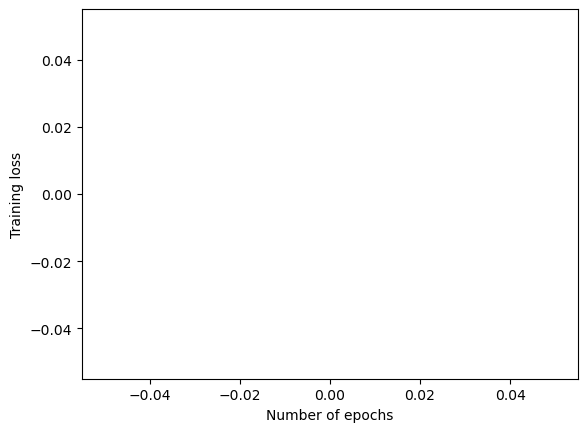

In [21]:
from tqdm import tqdm

#Defining hyperparameters
num_epochs = 20
eta = 0.001
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = eta, weight_decay=weight_decay)

#training
train_loss_list = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    train_loss = 0

    #Iterating over the data in batches
    model.train()
    progress = tqdm(train_loader)
    for i, (images, labels) in enumerate(progress):

        #extraction of images and target labels of the batch
        images = images.to(device)
        labels = labels.to(device)

        #calculating the model output and its loss
        outputs = model(images)
        loss = criterion(outputs, labels.long())

        #Updating the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        progress.set_description(f'loss:{loss.item()}:.4f')

    #Printing loss per epoch
    train_loss_list.append(train_loss/len(train_loader))
    print(f"Training loss = {train_loss_list[-1]}") 

#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")





In [22]:
#test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted = predicted.cpu().numpy()
        print(predicted) 


print(f"Accuracy: {100 * correct / total}")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy: 48.0


In [112]:

def generate_brownian_noise(length):
    # Generate white noise
    white_noise = np.random.randn(length)
    
    # Integrate the white noise to get Brownian noise
    brownian_noise = np.cumsum(white_noise)
    # Normalize the Brownian noise to have zero mean and unit variance
    brownian_noise -= np.mean(brownian_noise)
    std = np.std(brownian_noise) if np.std(brownian_noise) != 0 else 1
    brownian_noise /= std 

    
    return brownian_noise


def make_gravitational_waves_brown(
    # Cambiar el path 
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
):
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        cut = n-1 if cut==n else (1 if cut==0 else cut)
        rand1_length = cut # Ensure length is at least 1
        rand2_length = n - cut  # Ensure length is at least 1
        rand1 = generate_brownian_noise(rand1_length)  # Generate Brownian noise for padding
        rand2 = generate_brownian_noise(rand2_length)  # Generate Brownian noise for padding
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    gw = np.load("gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * generate_brownian_noise(N)  # Generate Brownian noise for the main signal
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
            
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, labels



In [113]:
#from data.generate_datasets import make_gravitational_waves
from pathlib import Path

n_signals = 1500
DATA = Path("./data")

noisy_brownsignals, gw_brownsignals, brown_labels = make_gravitational_waves_brown(
      n_signals=n_signals, r_min=0.025, r_max=0.65, n_snr_values=100
)


In [116]:
data = np.array(noisy_brownsignals)

#Scale the data
data = data / np.max(data)


# Convert the data end labels to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32).to(device)
labels = torch.tensor(blue_labels, dtype=torch.float32).to(device)


#Unsqueeze the data to add a channel dimension
data = data.unsqueeze(1)

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# print the amount of 1 in the labels
print(f"Number of 1s in the labels: {int(torch.sum(test_labels))}")
print(f"Number of 0s in the labels: {len(test_labels) - int(torch.sum(test_labels))}")



# Create TensorDatasets for training and testing
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Shape of the data
print(f"Shape of the training data: {train_data.shape}")



Number of 1s in the labels: 156
Number of 0s in the labels: 144
Shape of the training data: torch.Size([1200, 1, 8692])


In [44]:
data = np.array(noisy_brownsignals)

data = data*1000000000000


print(data)

print(np.max(data))


[[ 2.02367251e-06  4.41901798e-06  6.49620246e-06 ...  2.14523534e-06
   1.84357504e-06  9.65334479e-07]
 [-3.52828060e-06 -4.13729952e-07 -2.02042195e-07 ... -2.69073390e-06
  -3.38691467e-06 -3.41920797e-06]
 [ 4.91106245e-06  4.96743037e-06  5.03184119e-06 ...  4.07548454e-06
   5.17597114e-06  5.80659764e-06]
 ...
 [-1.97509138e-07 -2.07099688e-07 -2.28222085e-07 ... -2.76678191e-07
  -2.53168299e-07 -3.04202784e-07]
 [-1.80145629e-07 -1.20407705e-07 -1.10321014e-07 ... -5.76724584e-08
  -7.10404114e-08 -7.16454075e-08]
 [ 1.68418541e-07  6.06710808e-08  3.21436974e-09 ...  1.20909089e-07
   1.33632901e-07  1.40588904e-07]]
nan


In [56]:
Jerry = np.array(noisy_brownsignals)
np.isnan(Jerry).sum()

8

In [37]:
data = np.array(noisy_brownsignals)

data

array([[ 2.02367251e-18,  4.41901798e-18,  6.49620246e-18, ...,
         2.14523534e-18,  1.84357504e-18,  9.65334479e-19],
       [-3.52828060e-18, -4.13729952e-19, -2.02042195e-19, ...,
        -2.69073390e-18, -3.38691467e-18, -3.41920797e-18],
       [ 4.91106245e-18,  4.96743037e-18,  5.03184119e-18, ...,
         4.07548454e-18,  5.17597114e-18,  5.80659764e-18],
       ...,
       [-1.97509138e-19, -2.07099688e-19, -2.28222085e-19, ...,
        -2.76678191e-19, -2.53168299e-19, -3.04202784e-19],
       [-1.80145629e-19, -1.20407705e-19, -1.10321014e-19, ...,
        -5.76724584e-20, -7.10404114e-20, -7.16454075e-20],
       [ 1.68418541e-19,  6.06710808e-20,  3.21436974e-21, ...,
         1.20909089e-19,  1.33632901e-19,  1.40588904e-19]])

In [38]:
data = data*1000000000000

#Scale the data
data = data / np.max(data)

array([[ 2.02367251e-06,  4.41901798e-06,  6.49620246e-06, ...,
         2.14523534e-06,  1.84357504e-06,  9.65334479e-07],
       [-3.52828060e-06, -4.13729952e-07, -2.02042195e-07, ...,
        -2.69073390e-06, -3.38691467e-06, -3.41920797e-06],
       [ 4.91106245e-06,  4.96743037e-06,  5.03184119e-06, ...,
         4.07548454e-06,  5.17597114e-06,  5.80659764e-06],
       ...,
       [-1.97509138e-07, -2.07099688e-07, -2.28222085e-07, ...,
        -2.76678191e-07, -2.53168299e-07, -3.04202784e-07],
       [-1.80145629e-07, -1.20407705e-07, -1.10321014e-07, ...,
        -5.76724584e-08, -7.10404114e-08, -7.16454075e-08],
       [ 1.68418541e-07,  6.06710808e-08,  3.21436974e-09, ...,
         1.20909089e-07,  1.33632901e-07,  1.40588904e-07]])

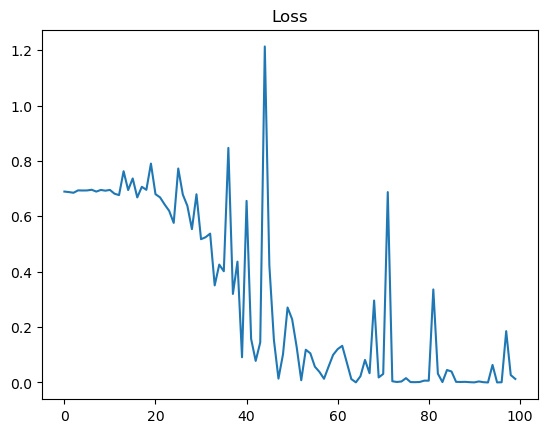

In [117]:
model = GWCNN().to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

losses = []

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels.long())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #save the loss of each epoch for plotting but only the first 2 digits
    losses.append(loss.item())


#plot the loss
plt.plot(losses) 
plt.title("Loss")
plt.show()

# Save the trained model
#torch.save(model.state_dict(), "GW_Paper.pth")

In [119]:
#test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted = predicted.cpu().numpy()
        print(predicted) 
    print(f"Accuracy: {100 * correct / total}")

[1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0]
[0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0]
[1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0]
[0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1]
[1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0]
[0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1]
[1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0]
[1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1]
[1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1]
[0 1 1 1 0 0 1 1 0 0 1 0]
Accuracy: 45.0


In [28]:
data

tensor([[[nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan]]], device='cuda:0')